In [1]:
import pandas as pd
import numpy as np
import os
import glob

from matplotlib import pyplot as plt
import matplotlib.ticker as plticker

## A lot of the below follows this guide youtube.com/watch?v=GrJP9FLV3FE&t=407s ##
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

pd.set_option('display.max_columns', 20)

In [2]:
# where the output will be saved
output_folder = 'output'

# location of pbp data
source_folder = '/Users/justynrodrigues/Documents/nfl/data/pbp/csv/'
all_files = glob.glob('/Users/justynrodrigues/Documents/nfl/data/pbp/csv/*.csv.gz')

df = pd.concat((pd.read_csv(__, low_memory=False, index_col=0) for __ in all_files))

In [3]:
def dynamic_window_ewma(x):
    '''
    Calculate rolling exponentially weighted EPA with a dynamic window size
    '''
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)

In [4]:
# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = df.loc[df['rush_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()
rushing_defense_epa = df.loc[df['rush_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()
passing_offense_epa = df.loc[df['pass_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()
passing_defense_epa = df.loc[df['pass_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

# lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam').apply(dynamic_window_ewma).values
rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam').apply(dynamic_window_ewma).values
passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam').apply(dynamic_window_ewma).values
passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam').apply(dynamic_window_ewma).values

#Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]
epa = epa.reset_index(drop=True)

epa.head()

,team,season,week,epa_rushing_offense,epa_shifted_rushing_offense,ewma_rushing_offense,ewma_dynamic_window_rushing_offense,epa_passing_offense,epa_shifted_passing_offense,ewma_passing_offense,ewma_dynamic_window_passing_offense,epa_rushing_defense,epa_shifted_rushing_defense,ewma_rushing_defense,ewma_dynamic_window_rushing_defense,epa_passing_defense,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2001,2,-0.228353,-0.048532,-0.224168,-0.224168,0.108686,-0.715064,-0.231613,-0.231613,0.001074,0.024131,0.042308,0.042308,0.419153,-0.196194,0.085527,0.085527
1,ARI,2001,3,-0.049025,-0.228353,-0.224955,-0.224955,-0.089342,0.108686,-0.167629,-0.167629,-0.034371,0.001074,0.034555,0.034555,0.621936,0.419153,0.148256,0.148256
2,ARI,2001,4,-0.041161,-0.049025,-0.192080,-0.192080,0.218148,-0.089342,-0.153000,-0.153000,0.100819,-0.034371,0.021675,0.021675,-0.027741,0.621936,0.236769,0.236769
3,ARI,2001,5,-0.575652,-0.041161,-0.164020,-0.164020,0.116517,0.218148,-0.083994,-0.083994,0.035007,0.100819,0.036390,0.036390,-0.061723,-0.027741,0.187590,0.187590
4,ARI,2001,6,0.003970,-0.575652,-0.240240,-0.240240,0.355932,0.116517,-0.046867,-0.046867,0.067612,0.035007,0.036134,0.036134,-0.046273,-0.061723,0.141426,0.141426


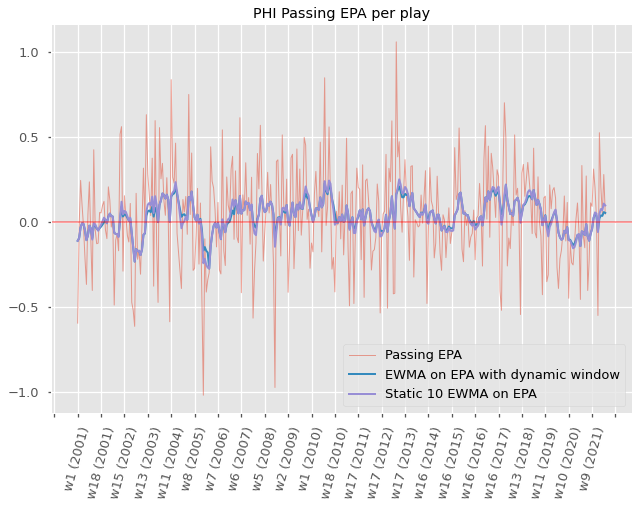

In [5]:
tm = epa.loc[epa['team'] == 'PHI', :].assign(
    season_week = lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
).set_index('season_week')

fig, ax = plt.subplots()

# this locator puts ticks at regular intervals
loc = plticker.MultipleLocator(base=16) 
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='x', rotation=75) 

ax.plot(tm['epa_shifted_passing_offense'], lw=1, alpha=0.5)
ax.plot(tm['ewma_dynamic_window_passing_offense'], lw=2)
ax.plot(tm['ewma_passing_offense'], lw=2);
plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)

ax.legend(['Passing EPA', 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA'])
ax.set_title('PHI Passing EPA per play')
plt.show()

In [6]:
schedule = df[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True).assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))
df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week']).merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))
df.head(3)

,season,week,home_team,away_team,home_score,away_score,home_team_win,epa_rushing_offense_home,epa_shifted_rushing_offense_home,ewma_rushing_offense_home,...,ewma_passing_offense_away,ewma_dynamic_window_passing_offense_away,epa_rushing_defense_away,epa_shifted_rushing_defense_away,ewma_rushing_defense_away,ewma_dynamic_window_rushing_defense_away,epa_passing_defense_away,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2018,1,PHI,ATL,18,12,1,0.141462,0.196937,-0.062824,...,0.125144,0.125144,0.141462,-0.256400,-0.088312,-0.088312,-0.259078,0.279086,0.025895,0.025895
1,2018,1,BAL,BUF,47,3,1,-0.109379,0.051773,-0.015440,...,-0.110661,-0.110661,-0.109379,0.005092,0.042288,0.042288,0.174117,-0.322741,-0.047343,-0.047343
2,2018,1,GB,CHI,24,23,1,-0.189240,-0.252986,0.029826,...,-0.121970,-0.121970,-0.189240,-0.052584,-0.077281,-0.077281,0.049345,-0.031244,-0.062557,-0.062557


In [7]:
target = 'home_team_win'
features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]

df = df.dropna()

X = df.loc[df['season'] != 2021, features].values
y = df.loc[df['season'] != 2021, target].values

clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [8]:
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print(f'Model Accuracy: {np.mean(accuracy_scores)}')
print(f'Neg log loss: {np.mean(log_losses)}')

Model Accuracy: 0.6349161343817413
Neg log loss: -0.6375192392409692


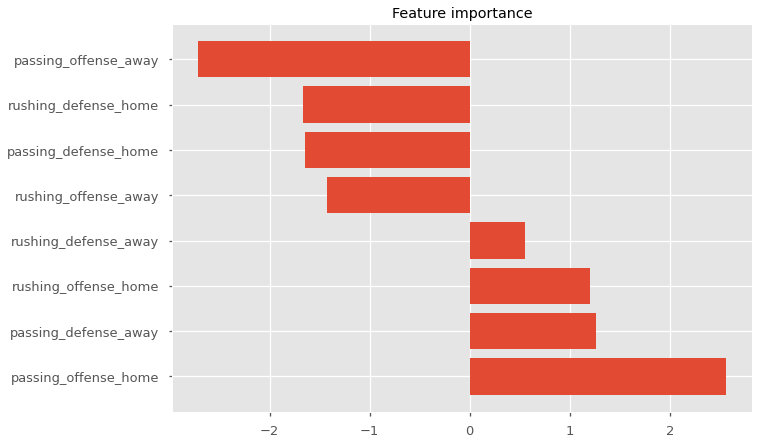

In [9]:
fig, ax = plt.subplots()
feature_names = ['_'.join(feature_name.split('_')[3:]) for feature_name in features]
coef_ = clf.coef_[0]

features_coef_sorted = sorted(zip(feature_names, coef_), key=lambda x:x[-1], reverse=True)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title('Feature importance')
ax.barh(features_sorted, coef_sorted);
plt.show()

In [10]:
df_2021 = df.loc[(df['season'] == 2021)].assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
)[['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

df_2021['actual_winner'] = df_2021.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
df_2021['predicted_winner'] = df_2021.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df_2021['win_probability'] = df_2021.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
df_2021['correct_prediction'] = (df_2021['predicted_winner'] == df_2021['actual_winner']).astype(int)

df_2021 = df_2021.drop(columns=['home_team_win_probability', 'home_team_win'])

df_2021.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(10)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,ARI,CAR,10,ARI,CAR,0.848422,0
1,LA,DET,7,LA,LA,0.842358,1
2,ARI,HOU,7,ARI,ARI,0.829924,1
3,TB,CAR,18,TB,TB,0.807764,1
4,BUF,MIA,8,BUF,BUF,0.807263,1
5,BUF,NYJ,18,BUF,BUF,0.799885,1
6,HOU,LA,8,LA,LA,0.796684,1
7,IND,JAX,10,IND,IND,0.794035,1
8,SF,HOU,17,SF,SF,0.791646,1
9,TB,CHI,7,TB,TB,0.791193,1


In [11]:
correct = df_2021.loc[df_2021['correct_prediction'] == 1].groupby('week')['correct_prediction'].sum()
num_games = df_2021.groupby('week')['correct_prediction'].size()
results = correct / num_games

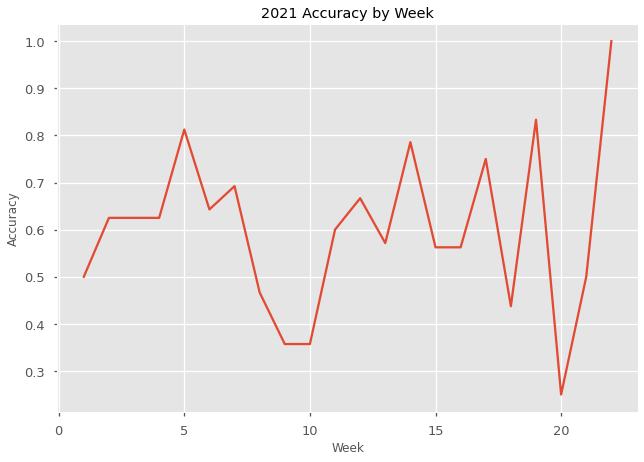

In [12]:
fig, ax = plt.subplots()
ax.set_title('2021 Accuracy by Week')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Week')
ax.plot(results.index, results.values)
plt.show()

In [13]:
print(df_2021.loc[df_2021['week'] == results.idxmax()].sort_values(by='win_probability', ascending=False))

     home_team away_team  week predicted_winner actual_winner  \
4558       CIN        LA    22               LA            LA   

      win_probability  correct_prediction  
4558         0.531285                   1  


In [14]:
df_2021.loc[df_2021['week'] > 18]

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
4546,LA,ARI,19,LA,LA,0.606912,1
4547,CIN,LV,19,CIN,CIN,0.627526,1
4548,BUF,NE,19,BUF,BUF,0.615214,1
4549,TB,PHI,19,TB,TB,0.678381,1
4550,KC,PIT,19,KC,KC,0.765168,1
4551,DAL,SF,19,DAL,SF,0.581506,0
4552,KC,BUF,20,KC,KC,0.512068,1
4553,TEN,CIN,20,TEN,CIN,0.601582,0
4554,TB,LA,20,TB,LA,0.597139,0
4555,GB,SF,20,GB,SF,0.554886,0


In [23]:
import itertools

def ewma(data, window):
    """
    Calculate the most recent value for EWMA given an array of data and a window size
    """
    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    scale = 1 / alpha_rev
    n = data.shape[0]
    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0] * alpha_rev**(r+1)
    pw0 = alpha * alpha_rev**(n-1)
    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out[-1]

In [16]:
# get 2022 schedule to get predictions

test = pd.read_csv('https://raw.githubusercontent.com/nflverse/nfldata/master/data/games.csv')
data_2022 = test.loc[(test['season'] == 2022)]


,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
6137,2022_01_BUF_LA,2022,REG,1,2022-09-08,Thursday,20:20,BUF,NaN,LA,...,NaN,00-0034857,00-0026498,Josh Allen,Matthew Stafford,Sean McDermott,Sean McVay,NaN,LAX01,SoFi Stadium
6138,2022_01_NO_ATL,2022,REG,1,2022-09-11,Sunday,13:00,NO,NaN,ATL,...,NaN,00-0031503,00-0032268,Jameis Winston,Marcus Mariota,Dennis Allen,Arthur Smith,NaN,ATL97,Mercedes-Benz Stadium
6139,2022_01_CLE_CAR,2022,REG,1,2022-09-11,Sunday,13:00,CLE,NaN,CAR,...,NaN,00-0033119,00-0034855,Jacoby Brissett,Baker Mayfield,Kevin Stefanski,Matt Rhule,NaN,CAR00,Bank of America Stadium
6140,2022_01_SF_CHI,2022,REG,1,2022-09-11,Sunday,13:00,SF,NaN,CHI,...,NaN,00-0037012,00-0036945,Trey Lance,Justin Fields,Kyle Shanahan,Matt Eberflus,NaN,CHI98,Soldier Field
6141,2022_01_PIT_CIN,2022,REG,1,2022-09-11,Sunday,13:00,PIT,NaN,CIN,...,NaN,00-0033869,00-0036442,Mitch Trubisky,Joe Burrow,Mike Tomlin,Zac Taylor,NaN,CIN00,Paycor Stadium


In [31]:

data_2021.loc[(data_2021['posteam'] == 'LA') | (data_2021['posteam'] == 'CIN')]

offense = data_2021.loc[(data_2021['posteam'] == 'LA') | (data_2021['posteam'] == 'CIN')]
defense = data_2021.loc[(data_2021['defteam'] == 'LA') | (data_2021['defteam'] == 'CIN')]

rushing_offense = offense.loc[offense['rush_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)['epa'].mean().rename(columns={'posteam': 'team'})
passing_offense = offense.loc[offense['pass_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)['epa'].mean().rename(columns={'posteam': 'team'})
rushing_defense = defense.loc[defense['rush_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)['epa'].mean().rename(columns={'defteam': 'team'})
passing_defense = defense.loc[defense['pass_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)['epa'].mean().rename(columns={'defteam': 'team'})

super_bowl_X = np.zeros(8)

for i, (tm, stat_df) in enumerate(itertools.product(['LA', 'CIN'], [rushing_offense, passing_offense, rushing_defense, passing_defense])):
    ewma_value = ewma(stat_df.loc[stat_df['team'] == tm]['epa'].values, 20)
    super_bowl_X[i] = ewma_value

predicted_winner = clf.predict(super_bowl_X.reshape(1, 8))[0]
predicted_proba = clf.predict_proba(super_bowl_X.reshape(1, 8))[0]

winner = 'LA' if predicted_winner else 'CIN'
win_prob = predicted_proba[-1] if predicted_winner else predicted_proba[0]

print(f'Model predicts {winner} will win the Super Bowl and has a {round(win_prob*100, 2)}% win probability')

Model predicts LA will win the Super Bowl and has a 68.41% win probability


In [36]:
df1 = df.assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
)[['home_team', 'away_team', 'week', 'season', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

df1['actual_winner'] = df1.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
df1['predicted_winner'] = df1.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df1['win_probability'] = df1.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
df1['correct_prediction'] = (df1['predicted_winner'] == df1['actual_winner']).astype(int)

df1 = df1.drop(columns=['home_team_win_probability', 'home_team_win'])

df1.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(10)

,home_team,away_team,week,...,actual_winner,win_probability,correct_prediction
0,PIT,CLE,6,...,PIT,0.932502,1
1,DEN,JAX,6,...,DEN,0.920630,1
2,PHI,HOU,4,...,PHI,0.919113,1
3,IND,HOU,10,...,IND,0.918054,1
4,CIN,CLE,12,...,CIN,0.916977,1
5,DAL,MIA,3,...,DAL,0.915141,1
6,LV,DAL,4,...,LV,0.910437,1
7,BAL,CLE,3,...,BAL,0.908178,1
8,BAL,ARI,2,...,BAL,0.901446,1
9,NE,NYJ,3,...,NE,0.901231,1


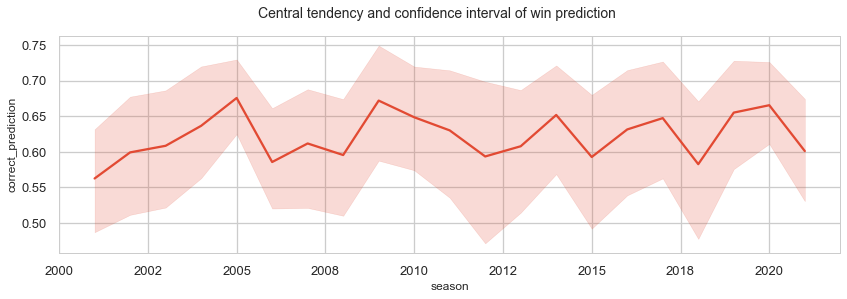

In [48]:
# Plot everything
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14.0, 4.0)
df2 = df1.groupby(['season', 'week'], as_index=False)['correct_prediction'].mean()#.sort_values(by='correct_prediction', ascending=False)

f, ax = plt.subplots()
sns.lineplot(x='season', y='correct_prediction', data=df2, ax=ax)
#ax[0].plot(rolling_avg.index, rolling_avg.spread_advantage, 'k:')
ax.set_ylabel("correct_prediction")

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.suptitle(
    'Central tendency and confidence interval of win prediction',
    fontsize=14)
plt.show()

In [ ]:
## create some new variables for the model ##
## most features taken directly from nflfastR ##

## SPREAD_LINE_DIFFERENTIAL ##
## instead of a point differential, use a spread line differential ##
## ie how close is the team to covering ##

df['spread_line_differential'] = np.where(
    df['posteam_type'] == 'home',
    -1 * df['spread_line'] + df['score_differential'],
    np.where(
        df['posteam_type'] == 'away',
        df['spread_line'] + df['score_differential'],
        np.nan
    ))

## elapsed share, spread_time, and Diff_Time_Ratio are all custom features from nflfastR's model ##
## https://raw.githubusercontent.com/mrcaseb/nflfastR/master/R/helper_add_ep_wp.R ##

## elapsed share ##
df['elapsed_share'] = (
    (3600 - df['game_seconds_remaining']) / 3600
)

df['posteam_spread'] = np.where(
    df['posteam_type'] == 'home',
    df['spread_line'],
    -1 * df['spread_line']
)

## spread_time ##
df['spread_time'] = df['posteam_spread'] * np.exp(-4 * df['elapsed_share'])

## Diff_Time_Ratio ##
df['diff_time_ratio'] = df['score_differential'] / np.exp(-4 * df['elapsed_share'])


## RECEIVE_2H_KO ##
## determine who received the first kickoff ##
kickoff_df = df[df['play_type'] == 'kickoff'].groupby(['game_id'])[['game_id','posteam_type']].head(1)

## add back to df ##
df = pd.merge(
    df,
    kickoff_df.rename(columns={
        'posteam_type' : 'received_first_ko'
    }),
    on=['game_id'],
    how='left'
)

## create receive 2nd half ko variable ##
df['receive_2h_ko'] = np.where(
    (df['game_half'] == 'Half1') & (df['posteam_type'] != df['received_first_ko']),
    1, 0
)

## IS_PAT || denote if a play is a pat ##
df['is_pat'] = np.where(
    df['play_type'] == 'extra_point',
    1, 0
)

## POSTEAM_IS_HOME || turn posteam_type into a boolean ##
df['posteam_is_home'] = np.where(
    df['posteam_type'] == 'home',
    1, np.where(
        df['posteam_type'] == 'away',
        0, np.nan
    ))

## COVER_RESULT ##
df['cover_result'] = np.where(
    df['posteam_type'] == 'home',
    np.where(
        -1 * df['spread_line'] + df['result'] > 0,
        1, 0),
    np.where(
        df['posteam_type'] == 'away',
        np.where(
            df['spread_line'] + -1 * df['result'] > 0,
            1, 0),
        np.nan
    ))

In [ ]:
model_df = df[[
    ## only needed for train/test split ##
    'game_id',
    'season',
    ## dependent var ##
    'cover_result',
    ## independent vars from WP model ##
    'spread_time',
    'score_differential',
    'diff_time_ratio',
    'posteam_is_home',
    'half_seconds_remaining',
    'game_seconds_remaining',
    'down',
    'ydstogo',
    'yardline_100',
    'posteam_timeouts_remaining',
    'defteam_timeouts_remaining',
    'receive_2h_ko',
    ## new features for CP model ##
    'is_pat',
    'spread_line_differential',
]].copy()

## remove NAs ##
model_df = model_df.dropna()

# save as a .zip to reduce size 
model_df.to_csv('output/nfl_df_cv.zip', index=False, compression=dict(method='zip', archive_name='nfl_df_cv.csv'))

In [ ]:
from sklearn.preprocessing import train_test_split

In [ ]:
X = model_df.drop(['cover_result'], axis=1)
y = model_df['cover_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)

## create first model to make sure evrything works ##
clf_xgb = xgb.XGBClassifier(objective='binary:logistic')
clf_xgb.fit(
    X_train,
    y_train,
    verbose=True,
    early_stopping_rounds = 10,
    eval_metric='aucpr',
    eval_set=[(X_test, y_test)]
)

In [ ]:
## Hyperparameter Optimization ##
## do some hyper parameter optimization ##
## Round 1 ##
param_grid = {
    'max_depth' : [3, 4, 5],
    'learning_rate' : [0.1, 0.05, 0.01],
    'gamma' : [0, 0.25, .5],
    'reg_lambda' : [10, 12, 15],
    'n_estimators' : [100, 500, 1000],
}

## set up grid search ##
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        subsample=0.9,
        colsample_bytree=0.75
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    cv=3
)

## fit ##
optimal_params.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)]
)

In [ ]:
clf_xgb.get_params()

In [ ]:
## Round 1 Results ##
## {'gamma': 0., 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 1}

## Round 2 ##
param_grid = {
    'max_depth' : [5, 6, 7],
    'learning_rate' : [0.005, 0.01, 0.025],
    'gamma' : [.25],
    'reg_lambda' : [6, 8, 10],
    'n_estimators' : [1000, 1250, 1500],
}

## {'gamma': 0.25, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'reg_lambda': 6}

In [ ]:
## Round 3 ##
param_grid = {
    'max_depth' : [5],
    'learning_rate' : [0.01],
    'gamma' : [.25],
    'reg_lambda' : [2, 4, 6],
    'n_estimators' : [1000, 1125],
}

## {'gamma': 0.25, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'reg_lambda': 6}

In [ ]:
## set up grid search ##
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        subsample=0.9,
        colsample_bytree=0.75
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    cv=3
)

In [ ]:
## fit ##
optimal_params.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)]
)

In [ ]:
## rerun w/ tuned params ##
clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    gamma=0.25,
    max_depth=5,
    reg_lambda=6,
    learning_rate=0.01,
    n_estimators=1000
)

clf_xgb.fit(
    X_train,
    y_train,
    verbose=True,
    early_stopping_rounds = 10,
    eval_metric='aucpr',
    eval_set=[(X_test, y_test)]
)

In [ ]:
## save model for future use ##
# f'{output_folder}/cp.model'
clf_xgb.save_model(
    '{0}/cp.model'.format(output_folder)
)

In [8]:
## a function for saving csvs of model performance locally. Not necessary to run ##
def score_models(model_arrays):
    bin_dfs = []
    confusion_dfs = []
    metric_dfs = []
    for i in model_arrays:
        df = i[0].copy()
        output_name = i[1]
        ## create predictions ##
        df['cover_prob'] = clf_xgb.predict_proba(df.drop(columns=['cover_result']))[:,1]
        ## bins ##
        bins = np.linspace(0, 1, 100)
        binned_df = df.groupby(
            np.digitize(df['cover_prob'], bins)
        ).agg(
            cover_average = ('cover_result', 'mean'),
            observations = ('cover_result', 'count'),
        ).reset_index().rename(columns={
            'index' : 'cover_prob'
        })
        binned_df['set_type'] = output_name
        ## confusion ##
        df['true_pos'] = np.where(
            (df['cover_prob'] > .5) &
            (df['cover_result'] == 1),
            1, 0)
        df['false_pos'] = np.where(
            (df['cover_prob'] > .5) &
            (df['cover_result'] == 0),
            1, 0)
        df['true_neg'] = np.where(
            (df['cover_prob'] < .5) &
            (df['cover_result'] == 0),
            1, 0)
        df['false_neg'] = np.where(
            (df['cover_prob'] < .5) &
            (df['cover_result'] == 1),
            1, 0)
        confusion_df = pd.DataFrame([{
            'set_type:' : output_name,
            'true_positive' : df['true_pos'].sum(),
            'false_positive' : df['false_pos'].sum(),
            'true_negative' : df['true_neg'].sum(),
            'false_negative' : df['false_neg'].sum(),
        }])
        ## log loss ##
        log_loss_score = log_loss(
            df['cover_result'],
            df['cover_prob'])
        auc = roc_auc_score(
            df['cover_result'],
            df['cover_prob'])
        metric_df = pd.DataFrame([{
            'set_type:' : output_name,
            'log_loss' : log_loss_score,
            'roc_auc' : auc,
        }])
        bin_dfs.append(binned_df)
        confusion_dfs.append(confusion_df)
        metric_dfs.append(metric_df)
    bin_output = pd.concat(bin_dfs)
    confusion_output = pd.concat(confusion_dfs)
    metrics_output = pd.concat(metric_dfs)
    ## output ##
    bin_output.to_csv(
        '{0}/binned_results.csv'.format(
            output_folder))
    confusion_output.to_csv(
        '{0}/confusion_results.csv'.format(
            output_folder))
    metrics_output.to_csv(
        '{0}/metric_results.csv'.format(
            output_folder))

'{output_folder}/cp.model'

In [5]:
test_arrays = [
    [training_df.drop(columns=['game_id', 'season', 'is_training_set']).copy(),
        'training'],
    [test_df.drop(columns=['game_id', 'season', 'is_training_set']).copy(),
        'test'],
    [model_validation_df.drop(columns=['game_id', 'season']).copy(),
        'validate'],
        ]

score_models(test_arrays)

output/cp.model
